# What's the Carbon Price of PGE Górnictwo i Energetyka Konwencjonalna S.A. ?

How can we use data from the European Union ETS transaction log retrieved using the EUTL ORM developed by Jan Abrell (https://abrell.eu/). The website https://www.euets.info/ is a human-friendly entry point to the data. The ORM python model can be downloaded from https://github.com/jabrell/eutl_orm. 

A description of the data and of the relational model can be found here: https://euets.info/static/download/Description_EUTL_database.pdf

In this notebook, we concentrate on one single installation/one single "operator holding account".

## To start this notebook

You must have set up the EUTL ORM database locally as explained in the `README.md`.

In [22]:
import sys
import os
sys.path.append('C:/Users/lmillischer/PycharmProjects/eutl_orm')
print(os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from eutl_orm import DataAccessLayer
from eutl_orm import Installation, Account    
from attic import paths
from attic.connection_settings import connectionSettings

%matplotlib inline
plt.rc('xtick', labelsize=14)  #fontsize of the x tick labels
plt.rc('ytick', labelsize=14)  #fontsize of the y tick labels
plt.rc('axes', titlesize=18)  #fontsize of the title
plt.rc('figure', titlesize=20)  #fontsize of the title
plt.rc('axes', labelsize=15)  #fontsize of the axes labels
plt.rc('legend', fontsize=15)  #fontsize of the axes labels

dal = DataAccessLayer(**connectionSettings)
session = dal.session

C:\Users\lmillischer\PycharmProjects\eutl_orm\scripts


## Starting point: Bełchatów power station

We start by looking at Bełchatów coal plant, coined by Wikipedia as the "most polluting power plant in the world":
https://en.wikipedia.org/wiki/Be%C5%82chat%C3%B3w_Power_Station

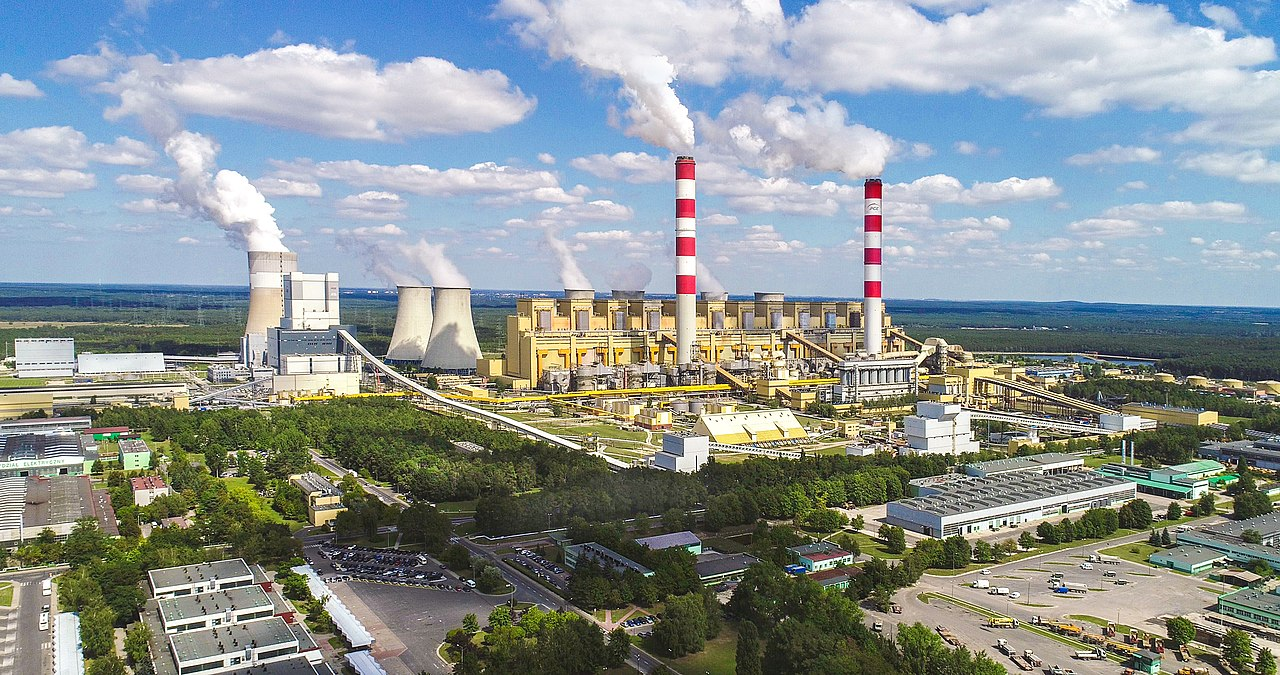

In [23]:
installation_id = "PL_1"
installation = session.query(Installation).get('PL_1')
print(f"{installation.name}")

PGE GiEK S.A. Oddział Elektrownia Bełchatów


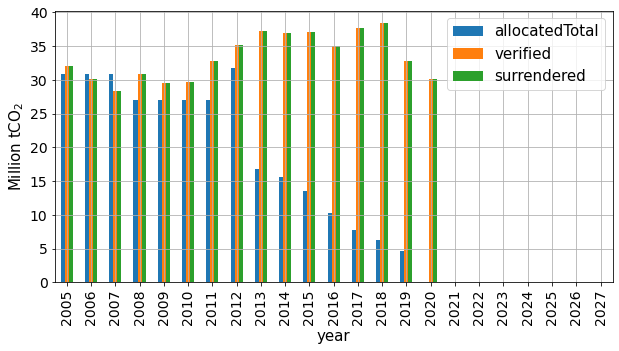

In [24]:
compliance_data = installation.get_compliance()
compliance_data = compliance_data[compliance_data.year < 2028]

ax = compliance_data[["year", "allocatedTotal", "verified", "surrendered"]]\
    .set_index("year").div(1000000)\
    .plot(kind="bar", figsize=(10,5), ylabel=r"Million tCO$_2$", grid=True)

## Account Holder: PGE Górnictwo i Energetyka Konwencjonalna S.A.

In [63]:
operator_holding_account = installation.accounts[0]
account_holder = operator_holding_account.accountHolder
account_holder_id = operator_holding_account.accountHolder.id
print(f"Account Holder: {account_holder.name} with id {account_holder_id}")

Account Holder: PGE Górnictwo i Energetyka Konwencjonalna S.A. with id 15306


Retrieve all currently active Operator Holding Account for this Account Holder:

In [42]:
#accounts = session.query(Account).filter(Account.accountHolder_id == account_holder_id) \
#.filter(Account.accountType_id == "100-7").all()

#
accounts = session.query(Account).filter(Account.accountHolder_id == account_holder_id).all()

acc_ids = [a.id for a in accounts]

[34448, 36161, 36164, 36168, 36177, 36211, 36214, 36217, 36349, 36432, 36690, 34583, 34584, 34585, 34597, 34598, 34666, 34670, 34672, 34729, 35072, 35073, 35074, 35092, 35123, 35260, 35369]
True


In [27]:
transaction_tables = []
for account in accounts:
    transaction_tables.append(account.get_transactions())

transactions = pd.concat(transaction_tables)

display(transactions.head())

# add date and datetime information to table (to price transactions with daily ETS price)
transactions["date"] = pd.to_datetime(transactions.index.date)
transactions["datetime"] = pd.to_datetime(transactions.index)

# aggregate transaction blocks into individual transactions
aggregated_transactions = transactions.groupby("transactionID").agg({"amount": "sum", "amount_directed": "sum",
                                                                     "transferringAccount_id": "first",
                                                                     "acquiringAccount_id": "first",
                                                                     "date": "first",
                                                                     "datetime": "first",
                                                                     "acquiringAccountName": "first",
                                                                     "transferringAccountName": "first",
                                                                     "transactionTypeMain": "first",
                                                                     "transactionTypeSupplementary": "first"})


,transactionTypeMain_id,transferringAccount_id,acquiringAccount_id,project_id,id,transactionID,transactionTypeSupplementary_id,unitType_id,amount,unitType,transactionTypeMain,acquiringAccountName,acquiringAccountType,transferringAccountName,transferringAccountType,direction,amount_directed,transactionTypeSupplementary
date,,,,,,,,,,,,,,,,,,
2014-09-04 10:00:56.691,10,34427,34448,NaN,1943737,EU220765,0,EUA_2013,308000,EU General Allowances (EUA),Internal - Internal transfer of unit/supplemen...,PL PGE Górnictwo i Energetyka Konwencjonalna S.A.,Trading Account,PL PGE Polska Grupa Energetyczna S.A.,Trading Account,1,308000,NaN
2014-09-04 10:02:32.454,10,34427,34448,2650.0,1944121,EU220865,0,CER,25963,CER - Certified Emission Reduction Unit,Internal - Internal transfer of unit/supplemen...,PL PGE Górnictwo i Energetyka Konwencjonalna S.A.,Trading Account,PL PGE Polska Grupa Energetyczna S.A.,Trading Account,1,25963,NaN
2014-09-04 10:02:32.454,10,34427,34448,2652.0,1944120,EU220865,0,CER,5349,CER - Certified Emission Reduction Unit,Internal - Internal transfer of unit/supplemen...,PL PGE Górnictwo i Energetyka Konwencjonalna S.A.,Trading Account,PL PGE Polska Grupa Energetyczna S.A.,Trading Account,1,5349,NaN
2014-09-04 10:02:32.454,10,34427,34448,2204.0,1944119,EU220865,0,CER,4693,CER - Certified Emission Reduction Unit,Internal - Internal transfer of unit/supplemen...,PL PGE Górnictwo i Energetyka Konwencjonalna S.A.,Trading Account,PL PGE Polska Grupa Energetyczna S.A.,Trading Account,1,4693,NaN
2014-09-04 10:02:32.454,10,34427,34448,2207.0,1944118,EU220865,0,CER,3367,CER - Certified Emission Reduction Unit,Internal - Internal transfer of unit/supplemen...,PL PGE Górnictwo i Energetyka Konwencjonalna S.A.,Trading Account,PL PGE Polska Grupa Energetyczna S.A.,Trading Account,1,3367,NaN


This list contains all the individual transactions involving an Operator Holding Account (= an installation) belonging to the Account Holder "PGE Górnictwo i Energetyka Konwencjonalna S.A.". We don't whant to price transactions which are internal to the group, since they do not represent a "real" market transaction but a mere re-allocation within an entity.

For that, we identify for each transaction the Account Holder for the "transferring" (from) and the "acquiring" (to) party, and drop all transactions involving the same Account Holder (PGE).

In [28]:
# map all Accounts to their Account Holder
print('Getting list of account and accountHolder IDs')
account_to_account_holder = pd.DataFrame(session.query(Account.id, Account.accountHolder_id).all())
n_accounts = len(account_to_account_holder)
print(n_accounts, 'found')
account_to_account_holder.columns = ['id', 'accountHolder_id']
account_to_account_holder = account_to_account_holder.dropna()  # L: why are there holes in this table?
print(n_accounts - len(account_to_account_holder), 'NAs dropped > this is weird')
account_to_account_holder["accountHolder_id"] = account_to_account_holder["accountHolder_id"].astype(int)

# temporary mapping for the Acquiring Account
mapping_tmp = account_to_account_holder.copy()
mapping_tmp = mapping_tmp.rename(columns={"id": "acquiringAccount_id",
                                          "accountHolder_id": "acquiringAccountHolder_id"})

print('merging acquiring account')
aggregated_transactions = aggregated_transactions.merge(mapping_tmp, how="left", on="acquiringAccount_id", indicator=True)
stat = aggregated_transactions.groupby('_merge')['acquiringAccount_id'].count()
print(stat)
del aggregated_transactions['_merge']

# temporary mapping for the Transferring Account
mapping_tmp = account_to_account_holder.copy()
mapping_tmp = mapping_tmp.rename(columns={"id": "transferringAccount_id",
                                          "accountHolder_id": "transferringAccountHolder_id"})

print('merging acquiring account')
aggregated_transactions = aggregated_transactions.merge(mapping_tmp, how="left", on="transferringAccount_id", indicator=True)
stat = aggregated_transactions.groupby('_merge')['acquiringAccount_id'].count()
print(stat)
del aggregated_transactions['_merge']

# drop all transactions internal to an Account Holder
internal_transactions_sel = aggregated_transactions.acquiringAccountHolder_id == aggregated_transactions.transferringAccountHolder_id
aggregated_transactions = aggregated_transactions[~internal_transactions_sel]

print('number of transactions that are non-internal', len(aggregated_transactions))


Getting list of account and accountHolder IDs
42007 found
723 NAs dropped > this is weird
merging acquiring account
_merge
left_only        0
right_only       0
both          2710
Name: acquiringAccount_id, dtype: int64
merging acquiring account
_merge
left_only        0
right_only       0
both          2710
Name: acquiringAccount_id, dtype: int64
number of transactions that are non-internal 2343


Load daily ETS prices from https://icapcarbonaction.com/en/ets-prices

date           object
ets_price     float64
ets_return    float64
dtype: object


Text(0.5, 1.0, 'price of EU ETS greenhouse emission allowances')

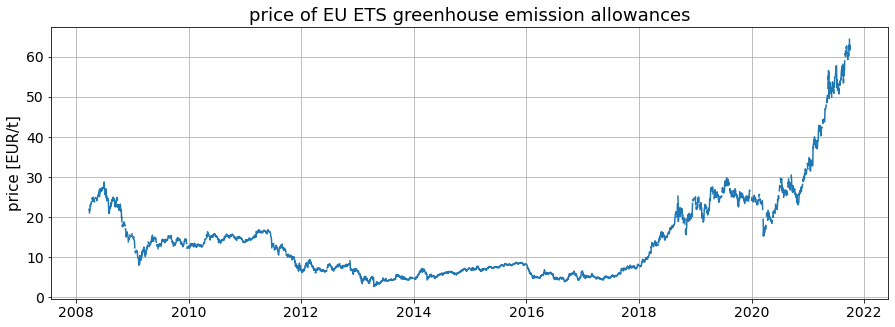

In [29]:
prices = pd.read_csv(paths.path_data / "ets.csv")
print(prices.dtypes)
prices["date"] = pd.to_datetime(prices["date"])
prices = prices[["date", "ets_price"]]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(prices.set_index("date"))
ax.grid()
ax.set_ylabel("price [EUR/t]")
ax.set_title("price of EU ETS greenhouse emission allowances")

Price each transaction at the price for this day

In [30]:
aggregated_transactions = aggregated_transactions.merge(prices, how='left', on="date", indicator=True)
stat = aggregated_transactions.groupby('_merge')['acquiringAccount_id'].count()
print(stat)
del aggregated_transactions['_merge']

_merge
left_only        0
right_only       0
both          2343
Name: acquiringAccount_id, dtype: int64


Assign a price of zero to transactions corresponding to
- the free allocation of allowances
- the deletion of allowances (surrendering)

In [31]:
print(len(session.query(Account).filter(Account.name == "EU EU ALLOCATION ACCOUNT").all()), 'alloc account found')
eu_allocation_account_id = session.query(Account).filter(Account.name == "EU EU ALLOCATION ACCOUNT").first().id

print(len(session.query(Account).filter(Account.name == "EU EU Allowance deletion").all()), 'deletion account found')
eu_deletion_account_id = session.query(Account).filter(Account.name == "EU EU Allowance deletion").first().id

free_allocation = aggregated_transactions["transferringAccount_id"] == eu_allocation_account_id
deletion = aggregated_transactions["acquiringAccount_id"] == eu_deletion_account_id
aggregated_transactions.loc[free_allocation, "ets_price"] = 0.0
aggregated_transactions.loc[deletion, "ets_price"] = 0.0


1 alloc account found
1 deletion account found


Compute the net monetary value of each transaction

In [32]:
# amount_directed > 0 : allowances are transferred TO the installation (e.g. free allocation, purchase...)
# amount_directed < 0 : allowances are transferred FROM the installation (e.g. deletion, sale...)
aggregated_transactions["value"] = aggregated_transactions["ets_price"] * aggregated_transactions["amount_directed"]

Compute the cumulative amount of allowances for the PGE Account Holder and the corresponding cumulative CO2 costs.

C:\Users\LMILLI~1\AppData\Local\Temp/ipykernel_5044/3281217914.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulative_amount['date'] = cumulative_amount['datetime'].dt.date


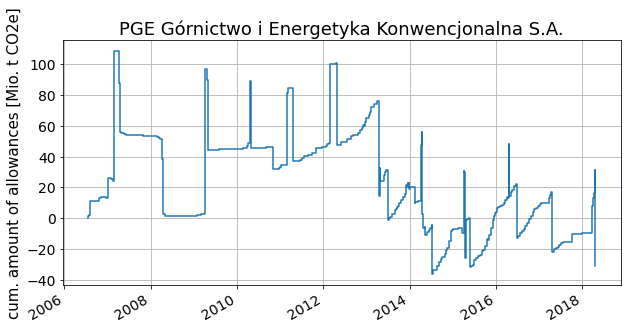

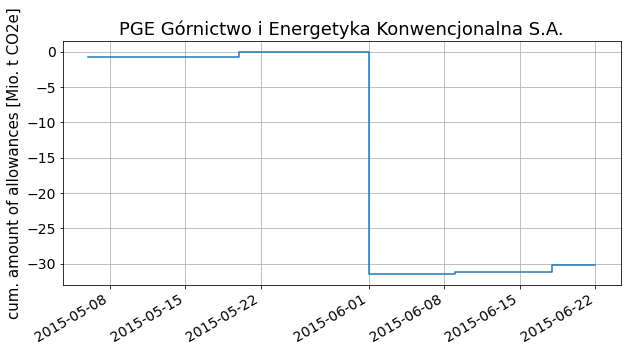

In [60]:
cumulative_value = aggregated_transactions[["datetime", "value"]]
cumulative_value = cumulative_value.groupby("datetime").sum()
cumulative_value = cumulative_value.cumsum()

cumulative_amount = aggregated_transactions[["datetime", "amount_directed"]]
cumulative_amount['date'] = cumulative_amount['datetime'].dt.date
cumulative_amount = cumulative_amount.groupby("date").sum()
cumulative_amount = cumulative_amount.cumsum()
#display(cumulative_amount.head())

cumulative_amount_zoom = cumulative_amount[(cumulative_amount.index > pd.Timestamp(2015,5,1)) & 
                                           (cumulative_amount.index < pd.Timestamp(2015,7,1))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cumulative_amount / 1e6, ds="steps-post")
ax.grid()
ax.set_ylabel("cum. amount of allowances [Mio. t CO2e]")
ax.set_title(account_holder.name)
fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cumulative_amount_zoom / 1e6, ds="steps-post")
ax.grid()
ax.set_ylabel("cum. amount of allowances [Mio. t CO2e]")
ax.set_title(account_holder.name)
fig.autofmt_xdate()

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(cumulative_value / 1e6, ds="steps-post")
# ax.grid()
# ax.set_ylabel("cum. net costs [Mio. EUR]")
# ax.set_title(account_holder.name)
# fig.autofmt_xdate()



In [68]:
#print(aggregated_transactions.dtypes)
selected_columns = ['amount', 'date', 'acquiringAccountName', 'transferringAccountName', 
                    'acquiringAccountHolder_id', 'transferringAccountHolder_id', 'transactionTypeMain',
                    'ets_price', 'value']
zoom = aggregated_transactions[(aggregated_transactions.date > pd.Timestamp(2015,5,22)) 
                        & (aggregated_transactions.date < pd.Timestamp(2015,6,3))][selected_columns]
display(zoom)

,amount,date,acquiringAccountName,transferringAccountName,acquiringAccountHolder_id,transferringAccountHolder_id,transactionTypeMain,ets_price,value
341,20500000,2015-06-01,PL Izba Rozliczeniowa Giełd Towarowych S.A.,PL PGE GiEK S.A. Oddział Elektrownia Bełchatów,15283,15306,Internal - Internal transfer of unit/supplemen...,7.24,-148420000.0
342,4000000,2015-06-01,PL Izba Rozliczeniowa Giełd Towarowych S.A.,PL PGE GiEK S.A. Oddział Elektrownia Opole,15283,15306,Internal - Internal transfer of unit/supplemen...,7.24,-28960000.0
343,7000000,2015-06-01,PL Izba Rozliczeniowa Giełd Towarowych S.A.,PL PGE GiEK S.A. Oddział Elektrownia Turów,15283,15306,Internal - Internal transfer of unit/supplemen...,7.24,-50680000.0


Looking at the last (big) sell to Izba for 166mEUR

In [35]:
aggregated_transactions.iloc[317]

amount                                                                   36886458
amount_directed                                                         -36886458
transferringAccount_id                                                      36161
acquiringAccount_id                                                         15478
date                                                          2015-04-15 00:00:00
datetime                                               2015-04-15 09:44:06.195000
acquiringAccountName                                     EU EU Allowance deletion
transferringAccountName            PL PGE GiEK S.A. Oddział Elektrownia Bełchatów
transactionTypeMain             Internal - Internal transfer of unit/supplemen...
transactionTypeSupplementary                                  Allowance surrender
acquiringAccountHolder_id                                                    6849
transferringAccountHolder_id                                                15306
ets_price       

In [36]:
session.query(Account).filter(Account.id == '36682').first().accountType_id


'100-12'

In [37]:
session.query(AccountT)

NameError: name 'AccountT' is not defined